In [1]:
# libraries
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

import os
import datetime
from IPython import display

In [2]:
from sklearn.metrics import mean_squared_error

In [3]:
tf.__version__

'2.8.0'

In [4]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
# Building a complex and powerful Recurrent Neural Network (RNN).
# It will be able to predict profitable trading signals.

In [6]:
# Using a Recurrent Neural Network that allows forward propagation and backward propagation. Only RNN allows backward propagation aka feedback connection, which is important as the model self-adjusts its nuerons weights and bias after it has predicted the value and compared it to the actual value and hence it knows what the loss function value or RMSE is, so that it knows what weights to adjust to decrease it.
# Example of RNN model is LSTM model which is designed for Time Series Analysis

In [7]:
# Build stock/crypto price prediction for next day, next 3 days (72 hours), next 7 days (daily prices), next month (daily prices).

In [8]:
# Gathering the data.
# Trying the Bitcoin BTC first.
# Downloading Last 5 years of data.
btc_data = pdr.get_data_yahoo(["BTC-USD"], start=datetime.datetime(2015, 12, 30), end=datetime.datetime.now())

In [9]:
btc_data

Attributes,Adj Close,Close,High,Low,Open,Volume
Symbols,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,,
2015-12-30,426.619995,426.619995,434.386993,422.084015,433.299988,46889400
2015-12-31,430.566986,430.566986,432.920990,418.734985,425.875000,45996600
2016-01-01,434.334015,434.334015,436.246002,427.515015,430.721008,36278900
2016-01-02,433.437988,433.437988,436.062012,431.869995,434.622009,30096600
2016-01-03,430.010986,430.010986,433.743011,424.705994,433.578003,39633800
...,...,...,...,...,...,...
2022-05-18,28720.271484,28720.271484,30618.716797,28720.271484,30424.478516,31285268319
2022-05-19,30314.333984,30314.333984,30430.751953,28708.955078,28720.359375,33773447707


In [10]:
# Converting multindex columns to single level.
btc_data.columns = [x[0] for x in btc_data.columns]

In [11]:
# Time Series data
ts_copy = btc_data.copy()

In [12]:
ts_copy = pd.Series(ts_copy.index)

In [13]:
ts_copy = pd.DataFrame(ts_copy)

In [14]:
# Explore data.
# Find Outliers and Empty values
# Empty values in any() method are considered np.NaN, 0 or False or "" empty string.
btc_data[~btc_data.any(axis=1)]

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,


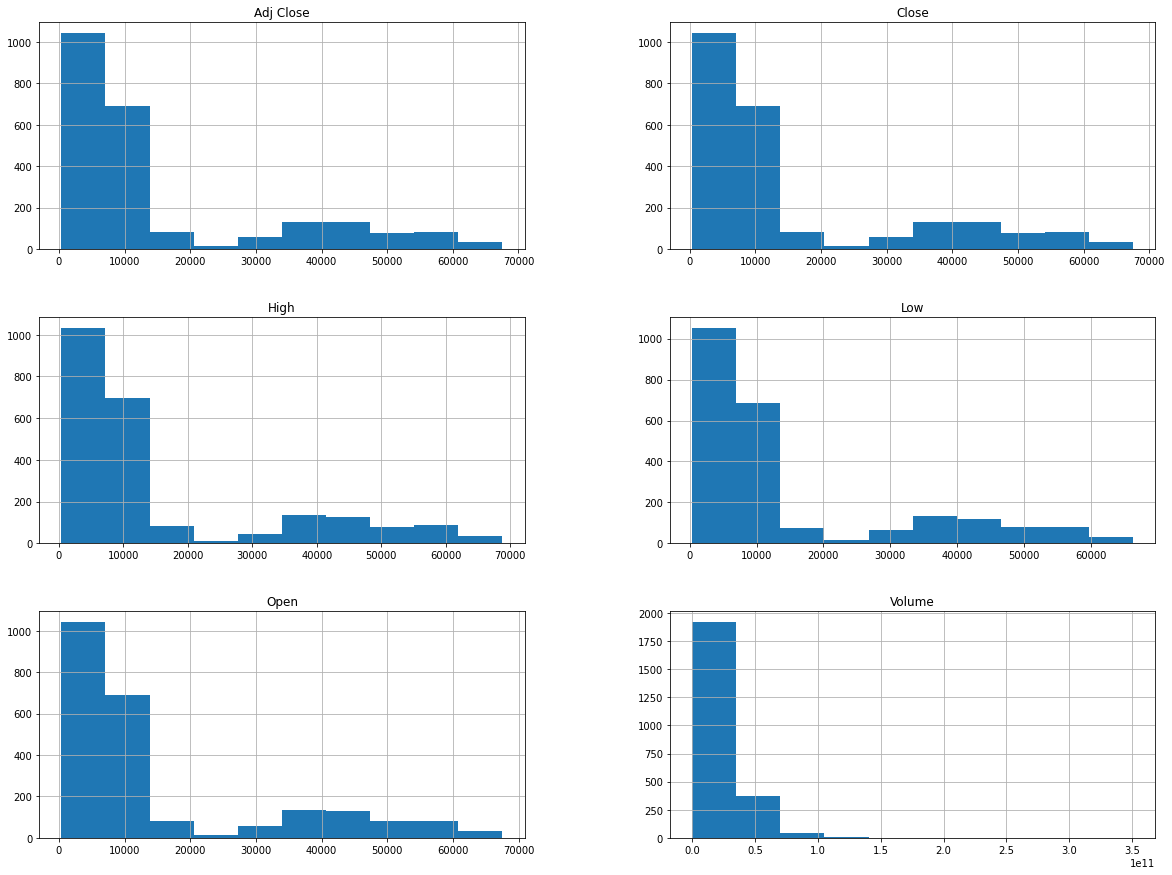

In [15]:
# Lets see the data distribution
btc_data.hist(figsize=(20, 15))
plt.show()

In [54]:
# Using Data Windowing to create labels for your inputted window
# The model will make set of predictions based on a window of consecutive samples from the price data
# The width (number of time steps) of the input and label windows.
# The time offset between them.
# Which features are used as inputs, labels, or both.
# Time step (1 day)

# in days

def sliding_window(input_width, label_width, df):
    indices = np.arange(len(df))
    column_length = len(df.columns)
    
    y_labels_df = df[['Date', 'Close']]

    store_inp_data = []
    store_labl_data = []

    for idx in indices[::input_width + label_width]:
        store_inp_data.append(df[idx: idx+input_width].values)
        store_labl_data.append(y_labels_df[idx+input_width: idx+input_width+label_width].values)
    
    return store_inp_data, store_labl_data


In [367]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1, label_width=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-label_width):
        a = dataset.values[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[["Date", "Close"]].values[i + look_back: i+look_back+label_width])
    return np.array(dataX), np.array(dataY)

In [368]:
input_df = btc_data.copy()

In [369]:
input_df_reset = input_df.reset_index()

In [391]:
# Using last t-6, t-5 ... t , to predict t+1. 
look_back=30
label_width=1

In [392]:
X_window_data, y_window_data = create_dataset(input_df_reset, look_back, label_width)

In [393]:
# Train Test Split
X_train_full, X_test, y_train_full, y_test = train_test_split(X_window_data, y_window_data, test_size=0.2, shuffle=False)

In [394]:
# Splitting further into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, shuffle=False)

In [395]:
X_train.shape

(1383, 30, 7)

In [396]:
X_test.shape

(461, 30, 7)

In [397]:
y_test.shape

(461, 1, 2)

In [398]:
# Be used as x-axis when plotting y_pred and y_test data on the y curve.
y_test_time_index = y_test[:, :, 0].reshape(-1)

In [399]:
# Getting rid of time data points
X_test = X_test[:,:,1:]
X_train = X_train[:,:,1:]
X_valid = X_valid[:,:,1:]

In [400]:
# Getting rid of time data points
y_train = y_train[:,:,1:]
y_valid = y_valid[:,:,1:]
y_test = y_test[:,:,1:]

In [401]:
# Reshaping data so that it can be inputted in requried 2d format to be transformed and scaled.
X_test_reshaped = X_test.reshape(-1, look_back * 6)
X_train_reshaped = X_train.reshape(-1, look_back * 6)
X_valid_reshaped = X_valid.reshape(-1, look_back * 6)
y_train_reshaped = y_train.reshape(-1, label_width * 1)
y_valid_reshaped = y_valid.reshape(-1, label_width * 1)
y_test_reshaped = y_test.reshape(-1, label_width * 1)

In [402]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
    ("std_scaler", StandardScaler()),
])

In [403]:
X_train_scaled = num_pipeline.fit_transform(X_train_reshaped)
X_valid_scaled = num_pipeline.transform(X_valid_reshaped)
X_test_scaled = num_pipeline.transform(X_test_reshaped)

In [404]:
y_train_scaled = num_pipeline.fit_transform(y_train_reshaped)
y_valid_scaled = num_pipeline.transform(y_valid_reshaped)
y_test_scaled = num_pipeline.transform(y_test_reshaped)

In [405]:
# reshaping the X_inputs back into 3 dimensional ndarray
X_test_3d = X_test_scaled.reshape(-1, look_back, 6)
X_train_3d = X_train_scaled.reshape(-1, look_back, 6)
X_valid_3d = X_valid_scaled.reshape(-1, look_back, 6)
y_train_3d = y_train_scaled.reshape(-1, label_width, 1)
y_valid_3d = y_valid_scaled.reshape(-1, label_width, 1)
y_test_3d = y_test_scaled.reshape(-1, label_width, 1)

In [406]:
# You need to make LSTM(Number) match your [batch, time_step, features] batch number.

shape = X_train_3d.shape

def create_lstm_model(shape):
    multi_lstm_model = tf.keras.Sequential([
        # Shape [batch, time_steps, features] => [batch, lstm_units]
        # If return_sequences=False, the default, the layer only returns the output of the final time step, giving the model time to warm up its internal state before making a single prediction:
        # If return_sequences=True, allows Training a model on multiple time steps simultaneously.
        tf.keras.layers.LSTM(units=shape[0],input_shape=(shape[1], shape[2]), return_sequences=False),
        # Shape => [batch, out_steps*features]
    #     tf.keras.layers.Dense(OUT_STEPS * num_features, kernel_initializer=tf.initializers.zeros()),
        # Shape => [batch, out_steps, features]
    #     tf.keras.layers.Reshape([OUT_STEPS, num_features]),

        # At the end we want to display just 1 feautre = 1 label.
        # Hence such output shape => [batch, time_steps, feature(1)]
        tf.keras.layers.Dense(units=1),
    ])
    
    return multi_lstm_model

In [407]:
model = create_lstm_model(shape)

In [408]:
model.compile(loss="mean_squared_error",
                        metrics="mean_absolute_error", optimizer="adam")

In [409]:
X_train_3d_1 = X_train_3d.astype("float32")
y_train_3d_1 = y_train_3d.astype("float32")

In [410]:
history = model.fit(X_train_3d_1, y_train_3d_1, epochs=20, validation_data=(X_valid_3d, y_valid_3d))

Epoch 1/20
44/44 [==============================] - 24s 528ms/step - loss: 0.1239 - mean_absolute_error: 0.2006 - val_loss: 0.9803 - val_mean_absolute_error: 0.5030
Epoch 2/20
44/44 [==============================] - 23s 524ms/step - loss: 0.0154 - mean_absolute_error: 0.0711 - val_loss: 0.5388 - val_mean_absolute_error: 0.3632
Epoch 3/20
44/44 [==============================] - 23s 524ms/step - loss: 0.0166 - mean_absolute_error: 0.0787 - val_loss: 0.7675 - val_mean_absolute_error: 0.4650
Epoch 4/20
44/44 [==============================] - 23s 522ms/step - loss: 0.0140 - mean_absolute_error: 0.0727 - val_loss: 0.5193 - val_mean_absolute_error: 0.3337
Epoch 5/20
44/44 [==============================] - 23s 522ms/step - loss: 0.0118 - mean_absolute_error: 0.0571 - val_loss: 0.5562 - val_mean_absolute_error: 0.3324
Epoch 6/20
44/44 [==============================] - 23s 523ms/step - loss: 0.0109 - mean_absolute_error: 0.0564 - val_loss: 0.3484 - val_mean_absolute_error: 0.2758
Epoch 7/20

In [411]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 1383)              7689480   
                                                                 
 dense_5 (Dense)             (None, 1)                 1384      
                                                                 
Total params: 7,690,864
Trainable params: 7,690,864
Non-trainable params: 0
_________________________________________________________________


In [412]:
# Saving the trained model to not spent 10 minutes training it.
model.save("crypto_30d_predict_1d.h5")

In [413]:
model.save_weights("crypto_30d_predict_1d_weights.h5")

In [415]:
# serialize model to JSON
model_json = model.to_json()
with open("crypto_30d_predict_1d_js.json", "w") as json_file:
    json_file.write(model_json)

In [417]:
# Testing the data on the test set and storing the rmse error
# After that plotting the actual labels vs predicted data.
mse_test = model.evaluate(X_test_3d, y_test_3d)

15/15 [==============================] - 2s 99ms/step - loss: 4.2297 - mean_absolute_error: 1.8310


In [418]:
y_predicted = model.predict(X_test_3d)

In [419]:
y_predicted_reshape = y_predicted.reshape(-1, label_width)
y_test_reshape = y_test_3d.reshape(-1, label_width)

In [420]:
y_predicted_inversed = num_pipeline.inverse_transform(y_predicted_reshape)

In [421]:
y_test_labels_inversed = num_pipeline.inverse_transform(y_test_reshape)

In [440]:
y_predicted_inversed_reshaped = y_predicted_inversed.reshape(-1)
y_test_labels_inversed_reshaped = y_test_labels_inversed.reshape(-1)

In [443]:
y_predicted_inversed_reshaped

array([40570.1484375 , 36882.77734375, 41068.25390625, 42153.14453125,
       41206.734375  , 47907.48046875, 41868.64453125, 48765.4453125 ,
       39954.97265625, 34219.94921875, 43824.03515625, 39491.57421875,
       21607.40429688, 40371.4375    , 41162.37890625, 34240.234375  ,
       41601.0546875 , 47272.98046875, 34246.2265625 , 41781.93359375,
       42666.5       , 43683.5       , 39618.41015625, 48681.1328125 ,
       44083.87890625, 46239.21875   , 46299.5390625 , 50847.7578125 ,
       45056.58984375, 46953.1875    , 43328.24609375, 49747.71484375,
       44113.15234375, 48685.8359375 , 47287.0546875 , 46224.7734375 ,
       43362.9453125 , 45458.90234375, 42136.328125  , 40772.79296875,
       47213.09375   , 44860.73046875, 45697.078125  , 47163.2890625 ,
       47491.171875  , 47142.25      , 46683.8203125 , 48853.08984375,
       45176.2578125 , 48001.0078125 , 47751.85546875, 45362.86328125,
       44468.3046875 , 47925.44140625, 47625.2578125 , 48034.4375    ,
      

In [439]:
y_test_labels_inversed_reshaped

array([47945.05859375, 49199.87109375, 52149.0078125 , 51679.796875  ,
       55888.1328125 , 56099.51953125, 57539.9453125 , 54207.3203125 ,
       48824.42578125, 49705.33203125, 47093.8515625 , 46339.76171875,
       46188.453125  , 45137.76953125, 49631.2421875 , 48378.98828125,
       50538.2421875 , 48561.16796875, 48927.3046875 , 48912.3828125 ,
       51206.69140625, 52246.5234375 , 54824.1171875 , 56008.55078125,
       57805.12109375, 57332.08984375, 61243.0859375 , 59302.31640625,
       55907.19921875, 56804.90234375, 58870.89453125, 57858.921875  ,
       58346.65234375, 58313.64453125, 57523.421875  , 54529.14453125,
       54738.9453125 , 52774.265625  , 51704.16015625, 55137.3125    ,
       55973.51171875, 55950.74609375, 57750.19921875, 58917.69140625,
       58918.83203125, 59095.80859375, 59384.3125    , 57603.890625  ,
       58758.5546875 , 59057.87890625, 58192.359375  , 56048.9375    ,
       58323.953125  , 58245.00390625, 59793.234375  , 60204.96484375,
      

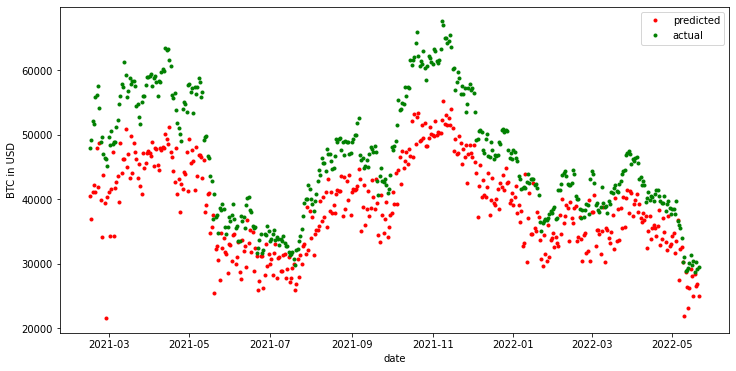

In [451]:
plt.figure(figsize=(12,6))
plt.plot(y_test_time_index, y_predicted_inversed_reshaped, "r.", label="predicted")
plt.plot(y_test_time_index, y_test_labels_inversed_reshaped, "g.", label="actual")
plt.xlabel("date")
plt.ylabel("BTC in USD")
plt.legend()
plt.show()

In [476]:
# Testing out the prediction for the next day BTC price prediction based on the input provided from today to today-29 days
# pdr.get_data_yahoo(["BTC-USD"], start=datetime.datetime(2015, 12, 30), end=datetime.datetime.now())
# Automatically predict BTC price for next day from today.
end_date = datetime.datetime.now().date()
lb_period = datetime.timedelta(look_back - 1)
start_date = end_date - lb_period

datetime.date(2022, 5, 22)

In [478]:
btc_data_30days = pdr.get_data_yahoo(["BTC-USD"], start=start_date, end=end_date)

In [514]:
next_day_prediction_date = btc_data_30days.index[-1] + datetime.timedelta(1)
next_day_date = next_day_prediction_date.strftime("%Y-%m-%d")

In [521]:
btc_df = btc_data_30days.copy()
btc_df_vals = btc_df.values

# scale the data with num_pipeline
btc_df_scaled = num_pipeline.fit_transform(btc_df_vals)

# reshape the data.
btc_df_reshaped = btc_df_scaled.reshape(1, btc_df_scaled.shape[0], btc_df_scaled.shape[1])

# predict the t+1 BTC price
y_pred_tomorrow_price = model.predict(btc_df_reshaped)

# inverse_transform the predicted BTC price
# this line below is just to set transformation for y_target correct
num_pipeline.fit_transform(y_test_reshaped)

y_pred_inversed = num_pipeline.inverse_transform(y_pred_tomorrow_price).reshape(-1)[0]

today_price = btc_df_vals[-1,1]

# If the predicted Crypto price higher than the previous day, then buy the crypto at current market price but lower than predicted price.
if y_pred_inversed > today_price:
    print(f"Predicted price for {next_day_date} is: {y_pred_inversed} USD")
    print(f"Issuing a buy order to Binance Exchange to buy 1 BTC at the price below the predicted price but at current or slightly higher today price at about {today_price} USD")
else:
    print(f"Predicted price for {next_day_date} is: {y_pred_inversed} USD")
    print("The predicted price is lower than current price {today_price}. No trading request issued. Suggesting to sell some of your bitcoin portfolio as the price is likely to be lower tomorrow")

Predicted price for 2022-05-23 is: 35472.74609375 USD
Issuing a buy order to Binance Exchange to buy 1 BTC at the price below the predicted price but at current or slightly higher today price at about 29969.482421875 USD


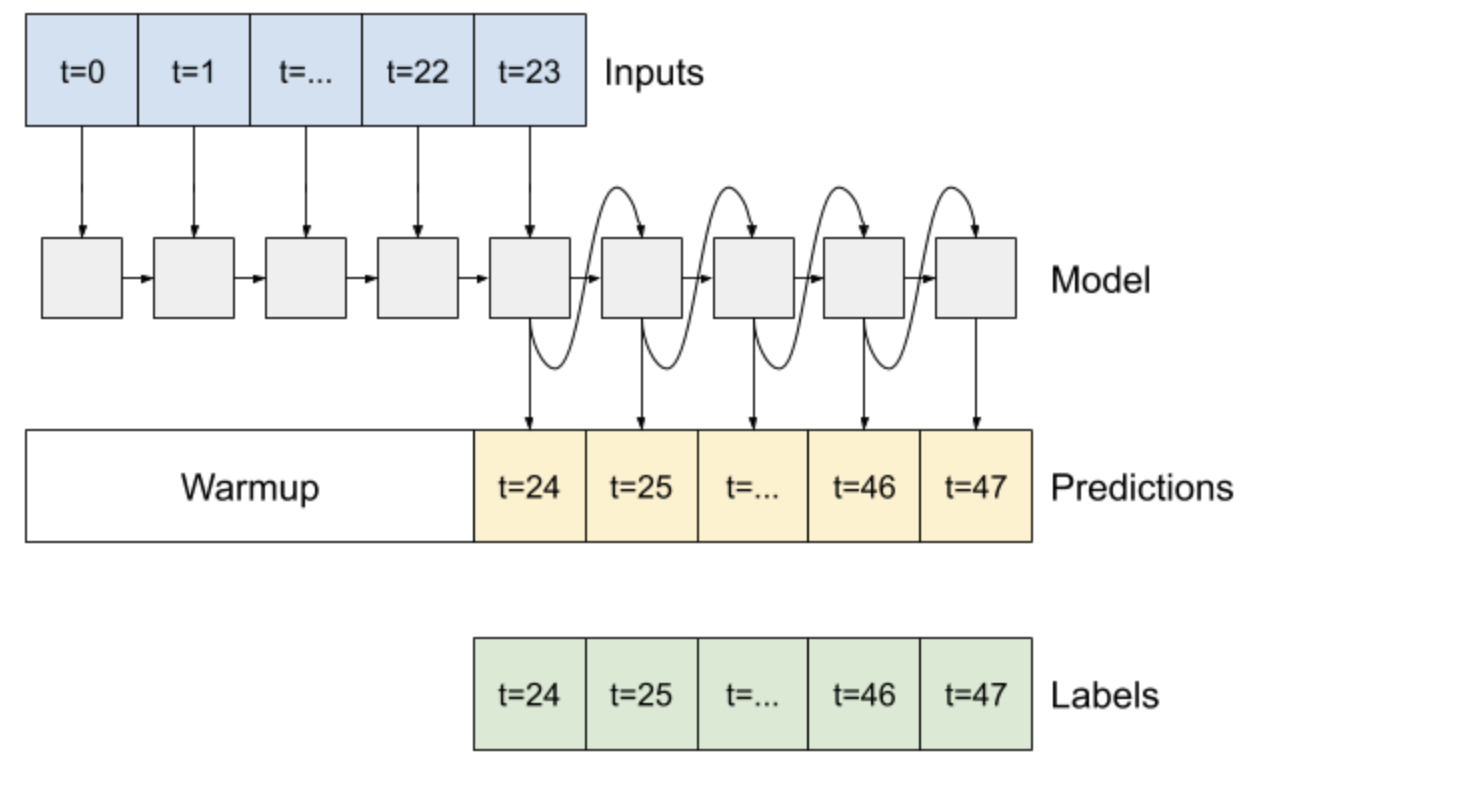

In [464]:
# Advanced Implementation of RNN LSTM model.
# Building a Autoregressive Model to predict into the future up to as many days you input.
# Then, each model's output can be fed back into itself at each step and predictions can be made conditioned on the previous one, like in the classic Generating Sequences With Recurrent Neural Networks.
from IPython.display import Image
Image(filename="autoregressive.png")